### Load the Modules and Data ###

I also rename some of the objectives so that it makes more intuitive sense that they should be minimized.

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from ema_workbench.util import load_results
experiments, outcomes = load_results(r'all_exploitation_10000_1.tar.gz')

In [4]:
outcomes['Difference in Met Demand'] = outcomes.pop('Equity in met demand')
outcomes['Difference in Arrival Time'] = outcomes.pop('Equity in arrival times')
outcomes['Time until containment'] = outcomes.pop('Speed')

### Let's do a first visualization of the outcome space ###

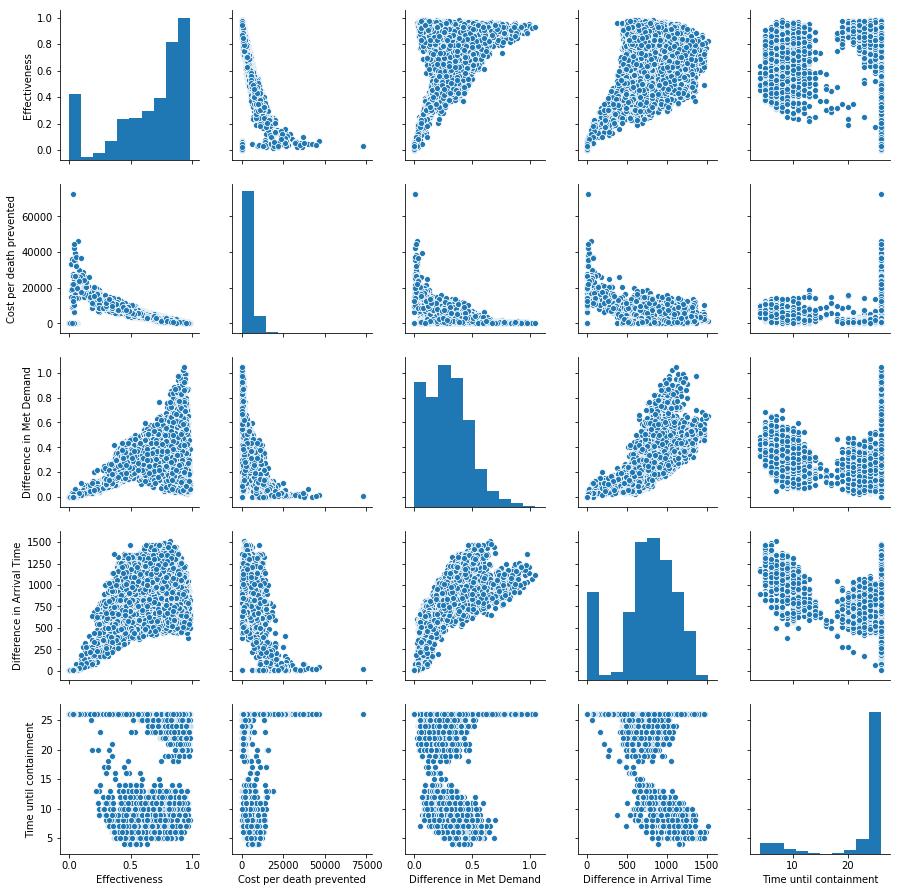

In [6]:
sns.pairplot(pd.DataFrame.from_dict(outcomes))
plt.show()

Some quick data cleaning for the quantitative analysis

In [5]:


cleaned_experiments = experiments.drop(labels=['exploration_ratio','policy','model'], axis=1)
cleaned_experiments = cleaned_experiments.rename(columns={'scenario_id': 'scenario'})

cleaned_experiments2 = cleaned_experiments.drop(labels=['scenario'], axis=1)

### Quantitative Analysis ###

First, we want to learn about the influence the uncertain input factors have on the model outcomes in general. For this feature scoring is used, which determines the influence of input factors using extremely randomized trees (extra trees) regression.

<IPython.core.display.Javascript object>


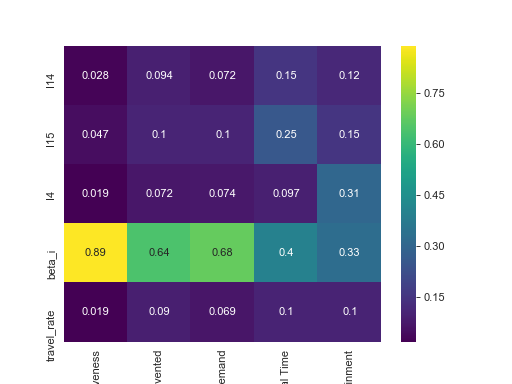

In [61]:
%matplotlib notebook

from ema_workbench.analysis import feature_scoring



fs = feature_scoring.get_feature_scores_all(cleaned_experiments2, outcomes)
sns.heatmap(fs, cmap='viridis', annot=True)
plt.show()

This shows that the community transmission rate (beta_i) is the most influential input factor for all objectives. For Effectiveness it is by far the most impotant one, whereas for Cost per Death Prevented and Difference in Met Demand the combined influence of all the other factors also plays a role. For Difference in Arrival Time the transmission rate is still the most influential, but the initial number of patients in regions 15 also has influence. Finally when studying the speed of the response, the transmission rate and the intitial number of patients in region 4 have the most influence.

Notably, the initial number of patients in region 14 and the travel rate do not seem te have a lot of influence on any of the factors.

Now we know the overall influence of the uncertain inputs at it seems that the transmission rate has by far the most effect. But we do not know the direction of this influence, nor does it explain the behaviours identified in the visual analysis of the scatterplot.

### Effectiveness ###

First, let's investigate the hypothesis from the qualitative analysis that low effectiveness rates are, counter-intuitively, caused by low transmissions. For this we can use PRIM, to see which parts of the input space correspond to specific sections of the outcome-space.

[MainProcess/INFO] 10000 points remaining, containing 1253 cases of interest
[MainProcess/INFO] box does not meet threshold criteria, value is 0.6622390891840607, returning dump box


<IPython.core.display.Javascript object>


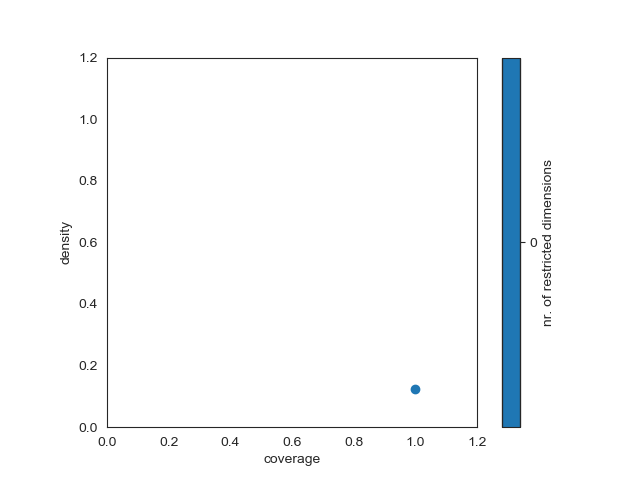

In [6]:
import matplotlib.pyplot as plt
%matplotlib notebook

from ema_workbench.analysis import prim
from ema_workbench import ema_logging

x = cleaned_experiments

y = outcomes['Effectiveness'] <= 0.2


numpy = np.array(y)

ema_logging.log_to_stderr(ema_logging.INFO)

prim_alg = prim.Prim(x, numpy, threshold=0.8)
box1 = prim_alg.find_box()

box1.show_tradeoff()
plt.show()

PRIM cannot find a a subspace in the input space which sufficiently explains efficiency scores under 0.2. This could mean that those poor scores are still due to the stochasticity in the spontaneous news mechanism, but that this is not strongly related to low transmission rates and intitial cases but more to simple ''bad luck''. 

However, with a high number of cases the probabiltiy of not receiving spontaneous news would become neligible, so high scores in efficiency could still be related to high transmission rates. Let's investigate using PRIM:

[MainProcess/INFO] 10000 points remaining, containing 4499 cases of interest
[MainProcess/INFO] mean: 0.9983566146261298, mass: 0.1217, coverage: 0.270060013336297, density: 0.9983566146261298 restricted_dimensions: 4


<IPython.core.display.Javascript object>


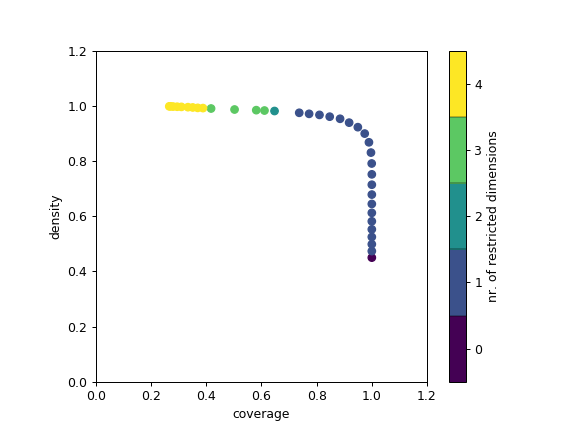

In [10]:
y = outcomes['Effectiveness'] > 0.8


numpy = np.array(y)

ema_logging.log_to_stderr(ema_logging.INFO)

prim_alg = prim.Prim(x, numpy, threshold=0.8)
box2 = prim_alg.find_box()

box2.show_tradeoff()
plt.show()

coverage    0.949322
density     0.922861
id                15
mass          0.4628
mean        0.922861
res_dim            1
Name: 15, dtype: object

          box 15                       
             min       max    qp values
beta_i  0.314883  0.499961  [0.0, -1.0]



<IPython.core.display.Javascript object>


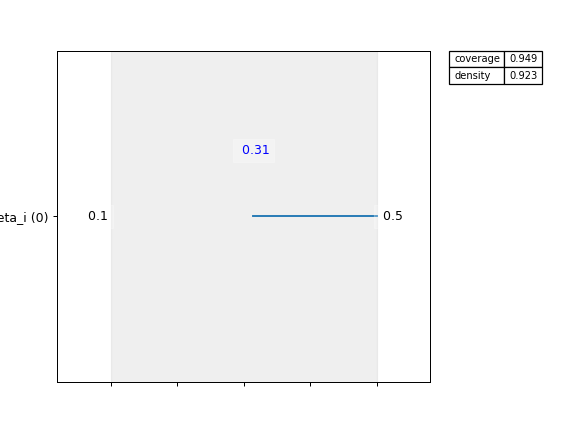

In [11]:
box2.inspect(15)
box2.inspect(15, style='graph')
plt.show()

And indeed, PRIM shows that high scores in effectiveness strongly correspond to transmission rate inputs in the upper half of its range. Following the ''bad luck'' hypothesis, this would suggest that the wide range of cases between 0.0 and 0.8 scores of effectiness is then predominantly explained by the stochasticity of the ''spontaneous news''  mechanism when the number of patients in a region remains below 80 for a longer time.



[MainProcess/INFO] 10000 points remaining, containing 5501 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.4176, coverage: 0.7591347027813125, density: 1.0 restricted_dimensions: 1


<IPython.core.display.Javascript object>


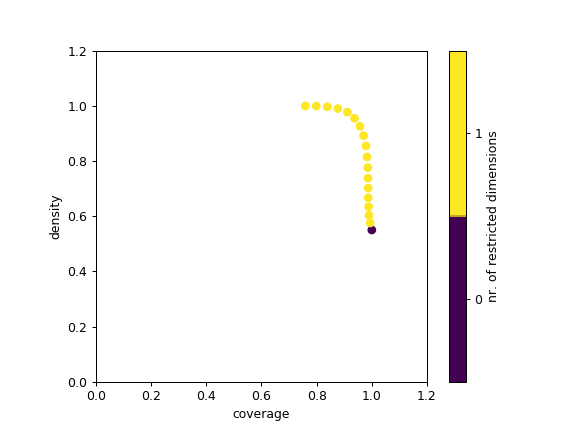

In [12]:
y = outcomes['Effectiveness'] <= 0.8


numpy = np.array(y)

ema_logging.log_to_stderr(ema_logging.INFO)

prim_alg = prim.Prim(x, numpy, threshold=0.8)
box3 = prim_alg.find_box()

box3.show_tradeoff()
plt.show()

coverage    0.911289
density     0.977384
id                13
mass          0.5129
mean        0.977384
res_dim            1
Name: 13, dtype: object

          box 13                       
             min       max    qp values
beta_i  0.100037  0.305145  [-1.0, 0.0]



<IPython.core.display.Javascript object>


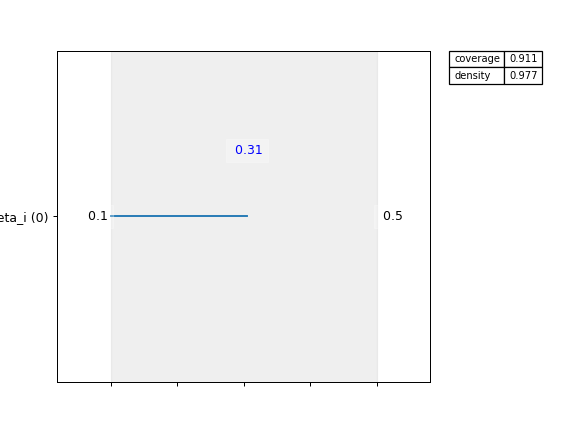

In [13]:
box3.inspect(13)
box3.inspect(13, style='graph')
plt.show()

PRIM shows that the wide range of scores in effectivenes (0.0 to 0.8) is only influenced by the transmission rate, while being unable to identify factors which explain the division within this set. This supports the ''bad luck'' hypothesis.

Let's use dimenional stacking to check these results:


<IPython.core.display.Javascript object>


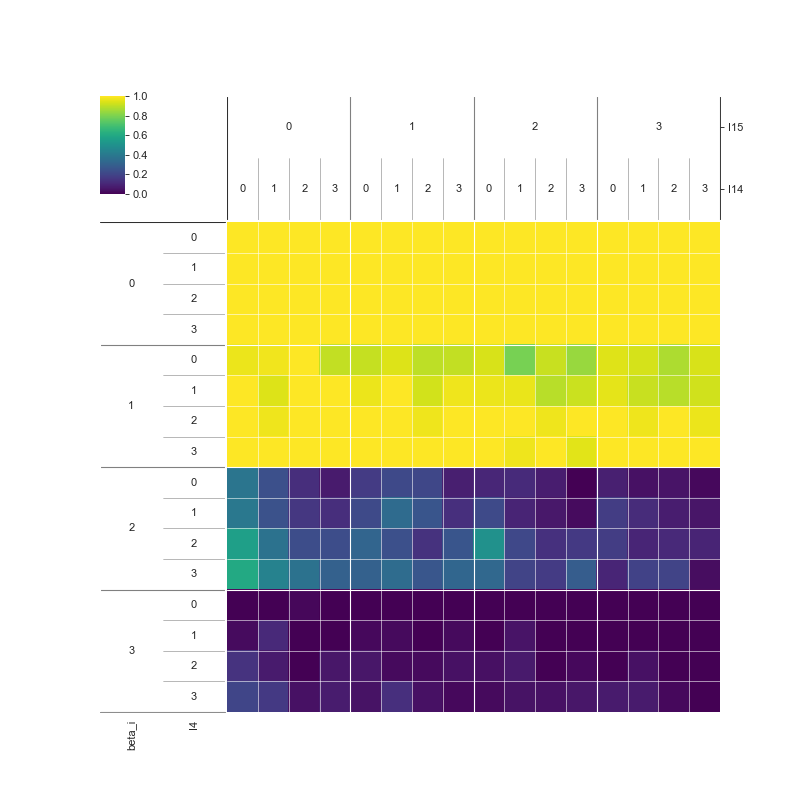

In [45]:
import matplotlib.pyplot as plt
from ema_workbench.analysis import dimensional_stacking

x = cleaned_experiments
y = outcomes['Effectiveness'] < 0.8
dimensional_stacking.create_pivot_plot(x,y, 2, nbins=4)
plt.show()

<IPython.core.display.Javascript object>


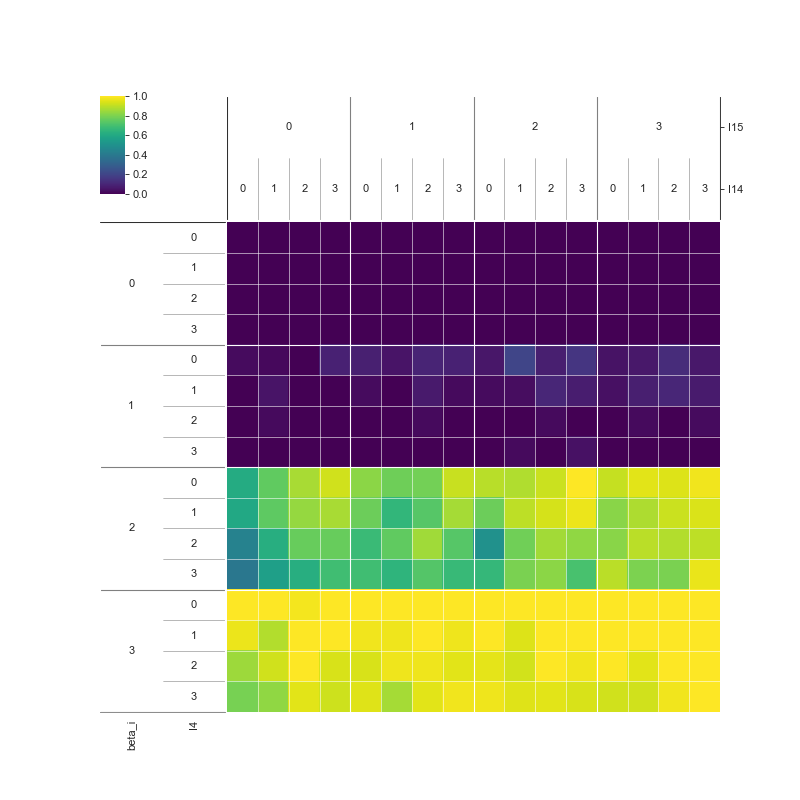

In [46]:
y = outcomes['Effectiveness'] > 0.8
dimensional_stacking.create_pivot_plot(x,y, 2, nbins=4)
plt.show()

Dimensional stacking confirms that the community transmission rate beta_i is the most important factor that explains differences in effectivness scores. 

Additionally, a small influence of I4 is visible, showing that if region 4 has a high number of cases, this actually leads to lower performance. This is because the number of intial cases in region 4 is small (with a maximum of 8 initial cases), meaning it will take a long time before it has a significant chance of generating spontaneous news (i.e. for 7 initial cases and a transmission rate of 0.32 it reaches 80 infections only after 23 timesteps, at which point the probability of spontaneous news approaches 1). This means that a high intial number of cases will lead to region 4 contributing a relatively large amount of deaths given its low chance of discovery.

### Cost per death prevented ###

Not a lot of (unexpected) variation in cost per live saved. Let's see if within reasonable scores we can still find out what is good. First we want to remove the outliers to get a better sense of the "normal" values.

In [16]:

condition = (outcomes['Cost per death prevented'] < 25000)
extracted = np.extract(condition, outcomes['Cost per death prevented'])

print(np.mean(extracted))
print(np.std(extracted))
print(np.median(extracted))

2910.2536097590505
3317.725571973243
1648.9819159789558


Let's look at the "best" half (median and under) of the results - PRIM can't find a good box, so let's try with the mean

[MainProcess/INFO] 10000 points remaining, containing 6493 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.4176, coverage: 0.6431541660249499, density: 1.0 restricted_dimensions: 1


<IPython.core.display.Javascript object>


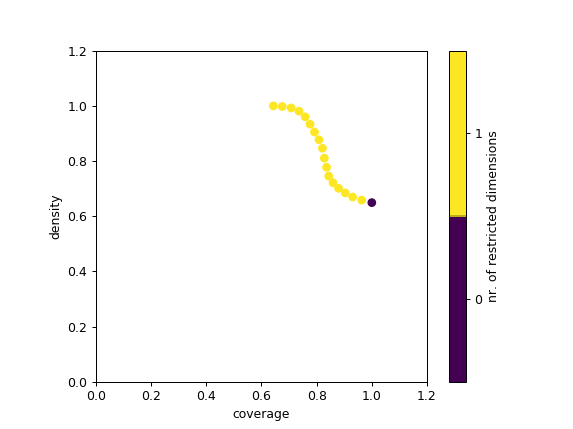

In [17]:
y = outcomes['Cost per death prevented'] <= 2910


numpy = np.array(y)

ema_logging.log_to_stderr(ema_logging.INFO)

prim_alg = prim.Prim(x, numpy, threshold=0.8)
box4 = prim_alg.find_box()

box4.show_tradeoff()
plt.show()

coverage    0.821038
density     0.846325
id                 9
mass          0.6299
mean        0.846325
res_dim            1
Name: 9, dtype: object

           box 9                                          
             min       max                       qp values
beta_i  0.248039  0.499961  [4.301631409737962e-269, -1.0]



<IPython.core.display.Javascript object>


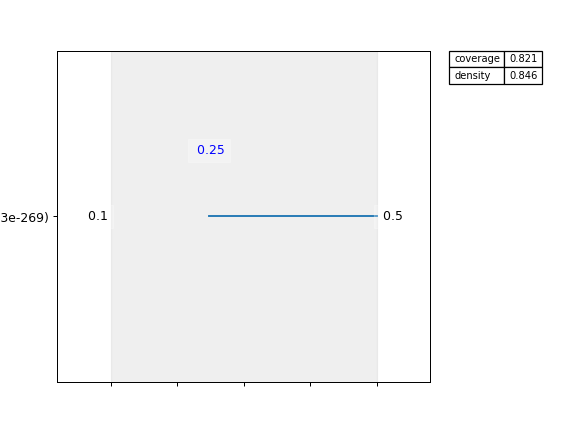

In [18]:
box4.inspect(9)
box4.inspect(9, style='graph')
plt.show()

So that's probably directly related to the effectiveness thing where high transmission rates cause high effectiveness 

[MainProcess/INFO] 10000 points remaining, containing 3507 cases of interest
[MainProcess/INFO] mean: 0.9351145038167938, mass: 0.0524, coverage: 0.13972055888223553, density: 0.9351145038167938 restricted_dimensions: 4


<IPython.core.display.Javascript object>


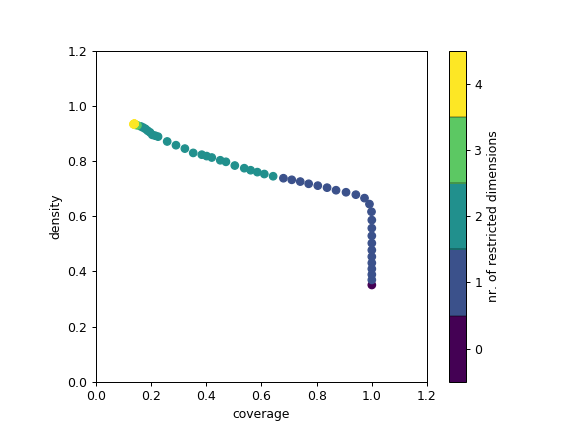

In [19]:
y = outcomes['Cost per death prevented'] > 2910


numpy = np.array(y)

ema_logging.log_to_stderr(ema_logging.INFO)

prim_alg = prim.Prim(x, numpy, threshold=0.8)
box5 = prim_alg.find_box()

box5.show_tradeoff()
plt.show()

coverage    0.740519
density     0.725622
id                20
mass          0.3579
mean        0.725622
res_dim            1
Name: 20, dtype: object

         box 20                                         
            min       max                      qp values
beta_i  0.14335  0.286508  [1.9074342261036624e-08, 0.0]



<IPython.core.display.Javascript object>


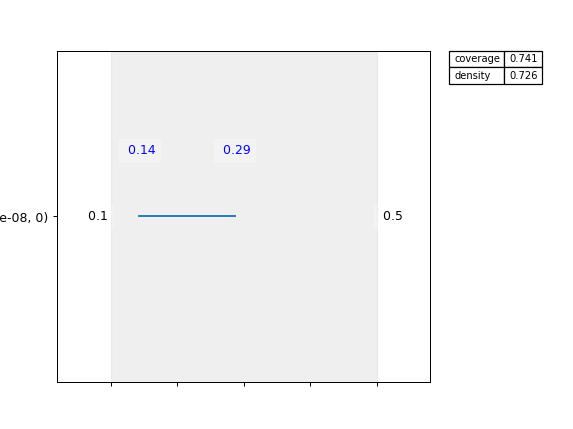

In [20]:
box5.inspect(20)
box5.inspect(20, style='graph')
plt.show()

And higher costs are related to low effectivness - that makes sense - if you spend resources during your response but you do not save many people, cost per person will be higher.

What about really high values for cost, i.e. > 10 000. Is there anything more at play?


[MainProcess/INFO] 10000 points remaining, containing 494 cases of interest
[MainProcess/INFO] box does not meet threshold criteria, value is 0.2204724409448819, returning dump box


<IPython.core.display.Javascript object>


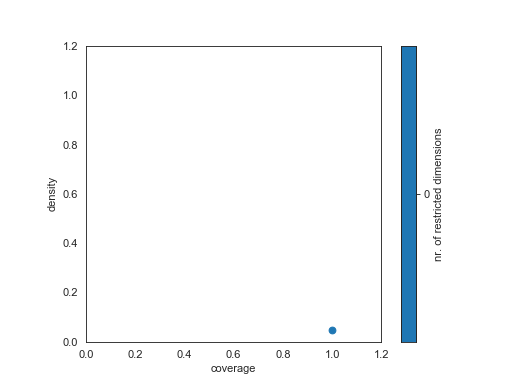

In [43]:
y = outcomes['Cost per death prevented'] > 10000


numpy = np.array(y)

ema_logging.log_to_stderr(ema_logging.INFO)

prim_alg = prim.Prim(x, numpy, threshold=0.8)
box5 = prim_alg.find_box()

box5.show_tradeoff()
plt.show()

<IPython.core.display.Javascript object>


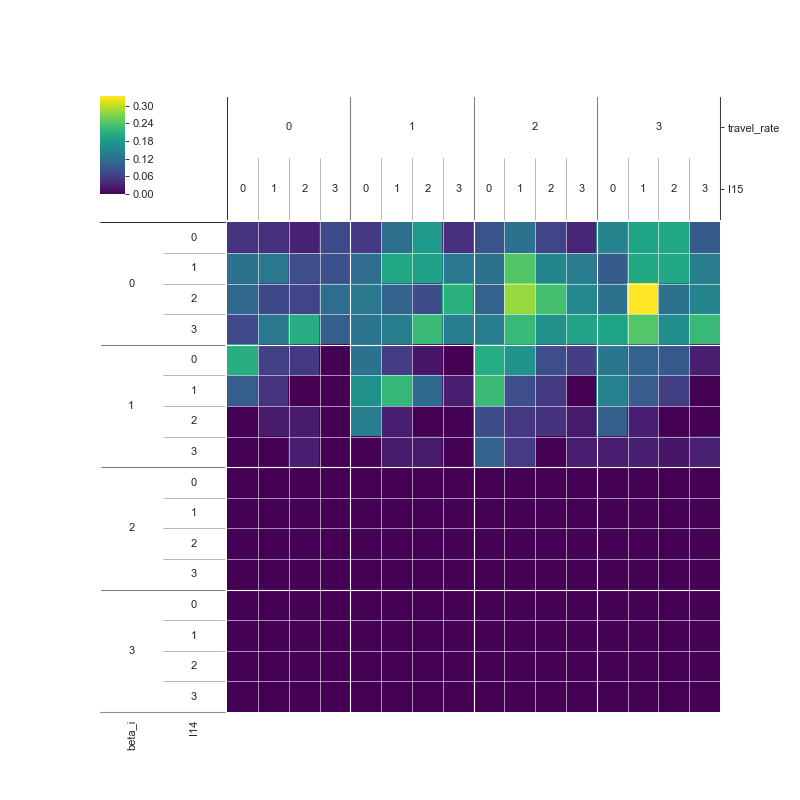

In [44]:
y = outcomes['Cost per death prevented'] > 10000
dimensional_stacking.create_pivot_plot(x,y, 2, nbins=4)
plt.show()

Nothing convincing here  - a slight influence of the transmission rate visible, which is again related to low effeciveness which in turn leads to higher cost. Speculating on the results, you could say that a high travel rate also has an effect. Two possible explanatians are that if travel rates are high, people move away from the 3 hotspot-regions, which means that spontaneous news from those regions occurs later because of a lower number of infected people. This could lead to lower effectiveness. Additionally, once a treatment centre is placed in one of these regions, the total number of patients will be lower as some have travelled away. This again leads to higher costs per patient.

### Equity - Difference in Met Demand ###
Given the visual inspection, there are two questions that are interesting for quantitative analysis:
- What factors are related to good performance on this objective?
- What causes the wide distribution of difference in met demand scores when effectiveness is high?

Let's start out with the first one

[MainProcess/INFO] 10000 points remaining, containing 7381 cases of interest
[MainProcess/INFO] mean: 0.9319727891156463, mass: 0.0588, coverage: 0.07424468229237231, density: 0.9319727891156463 restricted_dimensions: 5


<IPython.core.display.Javascript object>


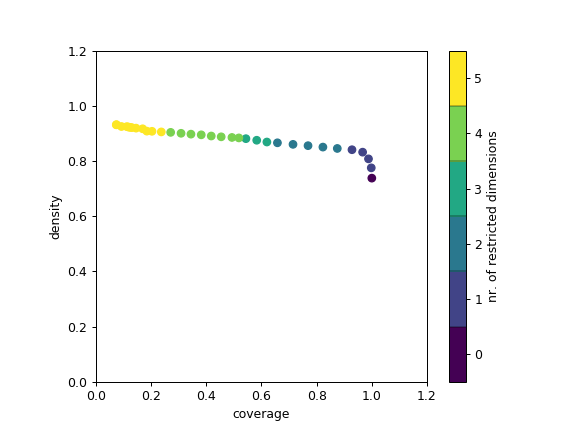

In [29]:
y = outcomes['Difference in Met Demand'] <= 0.4


numpy = np.array(y)

ema_logging.log_to_stderr(ema_logging.INFO)

prim_alg = prim.Prim(x, numpy, threshold=0.8)
box6 = prim_alg.find_box()

box6.show_tradeoff()
plt.show()

coverage    0.822653
density     0.850658
id                 6
mass          0.7138
mean        0.850658
res_dim            2
Name: 6, dtype: object

            box 6                                          
              min        max                      qp values
beta_i   0.100037   0.425749  [-1.0, 1.135835251604094e-97]
I15     25.000000  38.500000   [-1.0, 0.013729011677829982]



<IPython.core.display.Javascript object>


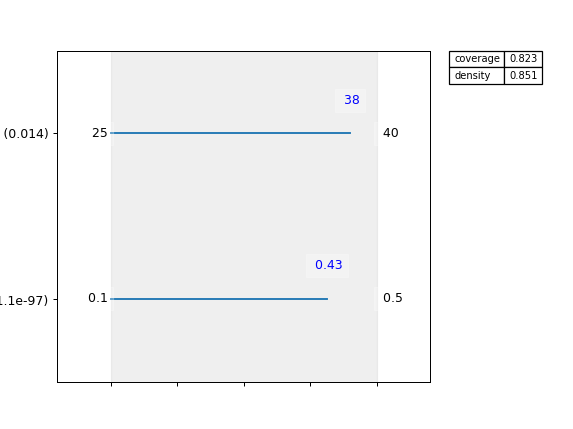

In [31]:
box6.inspect(6)
box6.inspect(6, style='graph')
plt.show()

[MainProcess/INFO] 10000 points remaining, containing 2619 cases of interest
[MainProcess/INFO] box does not meet threshold criteria, value is 0.45016611295681064, returning dump box


<IPython.core.display.Javascript object>


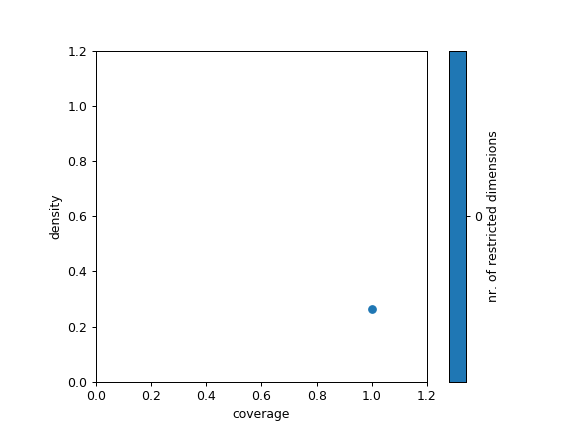

In [34]:
y = outcomes['Difference in Met Demand'] > 0.4


numpy = np.array(y)

ema_logging.log_to_stderr(ema_logging.INFO)

prim_alg = prim.Prim(x, numpy, threshold=0.8)
box7 = prim_alg.find_box()

box7.show_tradeoff()
plt.show()

So there seems to be some relation between reasonable scores in difference in met demand and not having the highest values for community transmission or initial number of cases in region 15. This trend is also visible at scores < 0.3 though less convincingly, and PRIM cannot show it is significant at scores < 0.2

What do these results tell us? 
Higher transmission rates lead to bigger unmet demand in regions where no response is active, but this does not explain why the difference in met and unmet demand is bigger because if no ETCs are active in an area, the fraction of met/unmet demand is zero regardless of the size of the unmet demand.

The influence of the initial cases in region 15 is also hard to explain at first glance. It might be helpful to first note the absence of influence from the travel rate. What does this abscence imply? You would think that this is important in met demand, as higher travel rates would result in more cases in more regions, leading to poorer met demand scores as these regions are unlikely to be discovered by an all-eploitative strategy. Its abscence suggests that, contrary to expectations, travel rate does not have a significant influence - which can be extrapolated into saying that small numbers of cases in multiple regions are not the dominant factor in determining met demand equity. 

This due to the way the objective is calculated. The objective looks at the difference between the ratio of unmet/met demand between regions, not at the absolute difference in demand. I.e., if regions have 2 or 5 cases, it doesn't matter since they are still likely not discovered by the all-exploitative policy, so the cummulative patients is 0. That means all these regions have met demand scores of 0. Therefore

Then why is it important to not have the maximum transmission rate and initial number of cases in region 15 for reasonable equity in met demand scores? High transmission rates in regions which are likely to be discovered (i.e. 14, 15)  -- more patients??

Let's use dimensional stacking




<IPython.core.display.Javascript object>


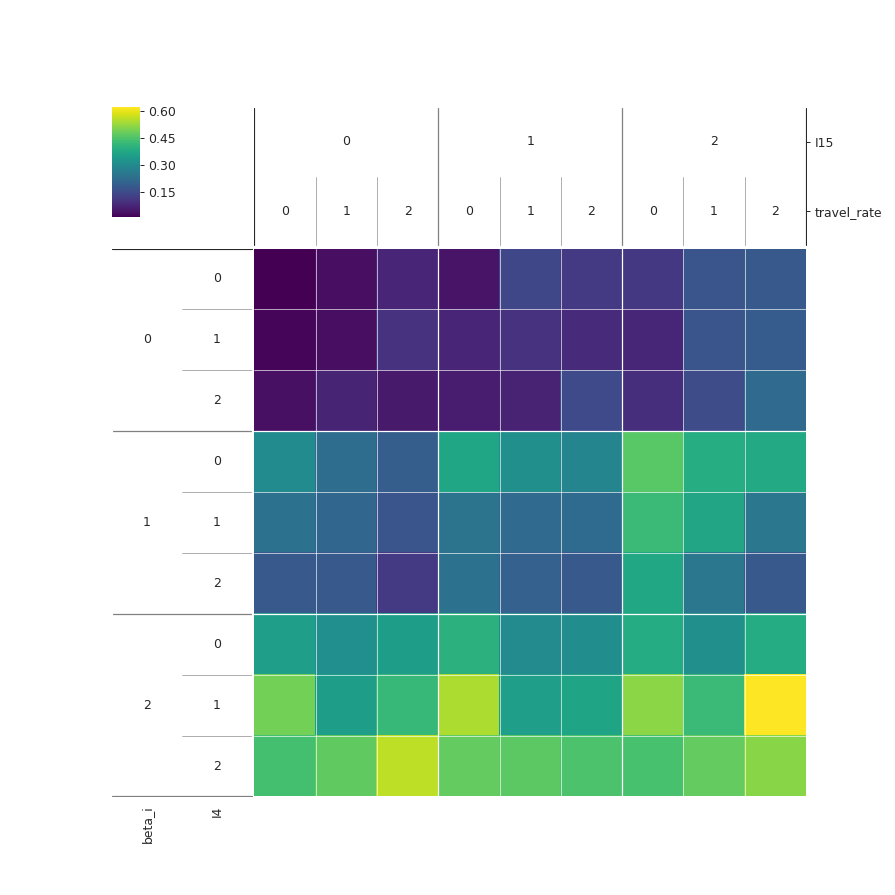

In [37]:
y = outcomes['Difference in Met Demand'] > 0.4
dimensional_stacking.create_pivot_plot(x,y, 2, nbins=3)
plt.show()

Moving on to the wide spread of equity scores given high efficiency

[MainProcess/INFO] 10000 points remaining, containing 2816 cases of interest
[MainProcess/INFO] mean: 0.9883720930232558, mass: 0.0516, coverage: 0.18110795454545456, density: 0.9883720930232558 restricted_dimensions: 5


<IPython.core.display.Javascript object>


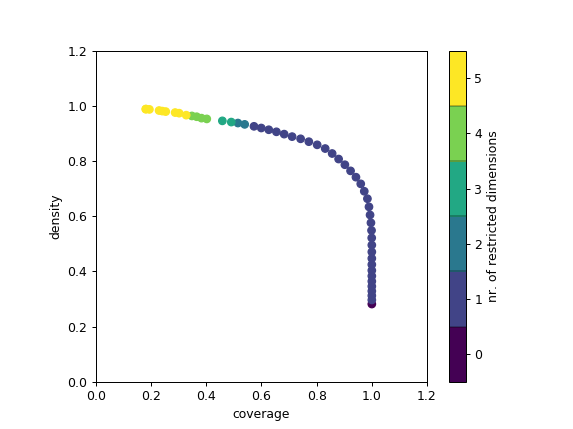

In [38]:
y1 = outcomes['Effectiveness'] > 0.8
y2 = outcomes['Difference in Met Demand'] < 0.4

y = []

for a, b in zip(y1,y2):
    y.append(a and b)
    
numpy = np.array(y)

ema_logging.log_to_stderr(ema_logging.INFO)

prim_alg = prim.Prim(x, numpy, threshold=0.8)
box8 = prim_alg.find_box()

box8.show_tradeoff()
plt.show()    


coverage    0.830966
density     0.845376
id                25
mass          0.2768
mean        0.845376
res_dim            1
Name: 25, dtype: object

          box 25                                          
             min       max                       qp values
beta_i  0.332052  0.442749  [0.0, 1.4417131394441456e-155]



<IPython.core.display.Javascript object>


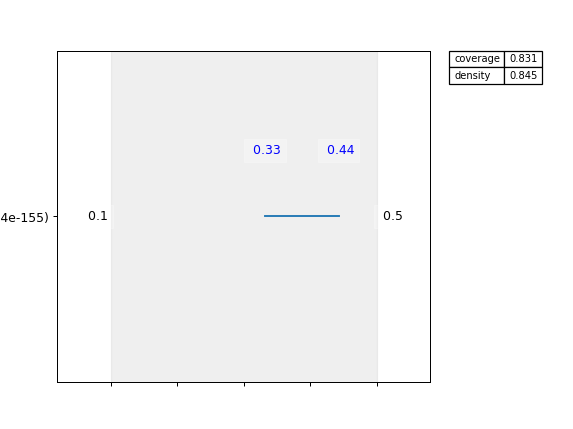

In [40]:
box8.inspect(25)
box8.inspect(25, style='graph')
plt.show()

[MainProcess/INFO] 10000 points remaining, containing 1683 cases of interest
[MainProcess/INFO] mean: 0.8874045801526718, mass: 0.0524, coverage: 0.27629233511586454, density: 0.8874045801526718 restricted_dimensions: 4


<IPython.core.display.Javascript object>


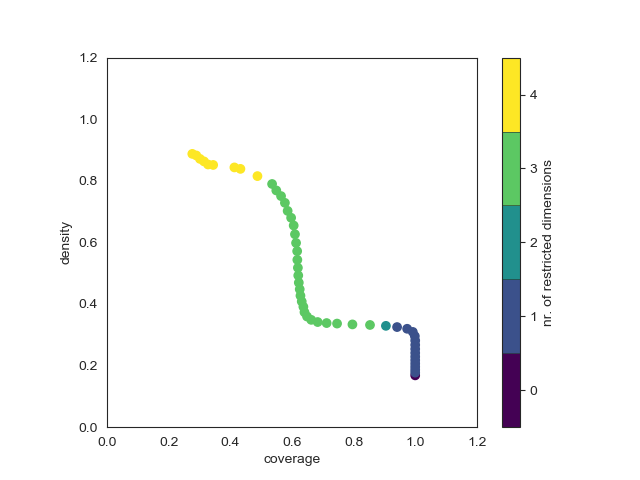

In [13]:
y1 = outcomes['Effectiveness'] > 0.8
y2 = outcomes['Difference in Met Demand'] > 0.4

y = []

for a, b in zip(y1,y2):
    y.append(a and b)
    
numpy = np.array(y)

ema_logging.log_to_stderr(ema_logging.INFO)

prim_alg = prim.Prim(x, numpy, threshold=0.8)
box9 = prim_alg.find_box()

box9.show_tradeoff()
plt.show()   

coverage     0.54902
density     0.768719
id                40
mass          0.1202
mean        0.768719
res_dim            3
Name: 40, dtype: object

                box 40                                        
                   min        max                    qp values
travel_rate   0.040004   0.096939   [-1.0, 0.4906326706865479]
beta_i        0.438685   0.499961                  [0.0, -1.0]
I15          27.500000  40.000000  [0.22207990427296503, -1.0]



<IPython.core.display.Javascript object>


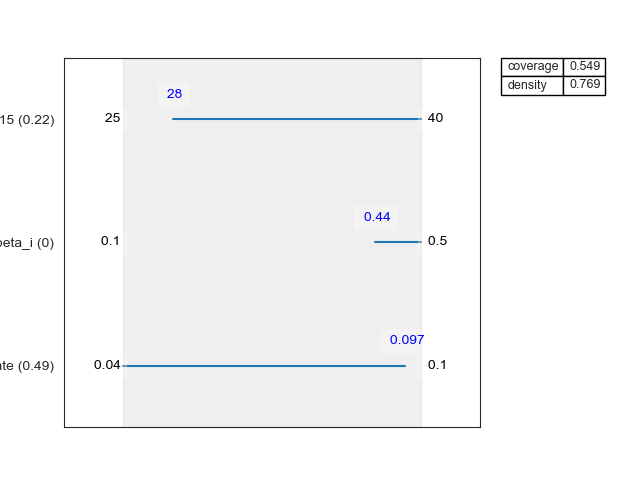

In [18]:
box9.inspect(40)
box9.inspect(40, style='graph')
plt.show()

It looks like PRIM has a hard time finding a good box - perhaps PCA preprocessing can help



[MainProcess/INFO] 10000 points remaining, containing 1683 cases of interest
[MainProcess/INFO] mean: 0.8523622047244095, mass: 0.0508, coverage: 0.25727866904337493, density: 0.8523622047244095 restricted_dimensions: 5


<IPython.core.display.Javascript object>


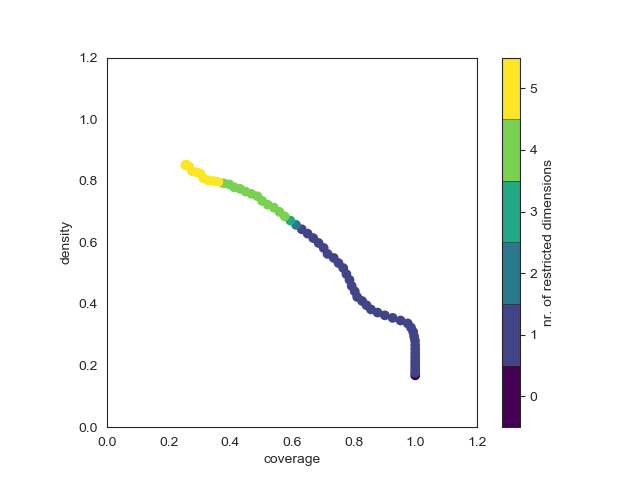

coverage    0.613191
density     0.656906
id                36
mass          0.1571
mean        0.656906
res_dim            2
Name: 36, dtype: object

       box 36                                       
          min       max                    qp values
r_4 -2.111886 -1.137012                  [-1.0, 0.0]
r_0 -1.519740  2.917490  [0.12489950146087453, -1.0]



In [21]:
y1 = outcomes['Effectiveness'] > 0.8
y2 = outcomes['Difference in Met Demand'] > 0.4

y = []

for a, b in zip(y1,y2):
    y.append(a and b)
    
numpy = np.array(y)

ema_logging.log_to_stderr(ema_logging.INFO)

rotated_experiments, rotation_matrix = prim.pca_preprocess(x, numpy)

prim_obj = prim.Prim(rotated_experiments, numpy, threshold=0.8)
box = prim_obj.find_box()

box.show_tradeoff()
box.inspect(36)
plt.show()

In [11]:
print(rotation_matrix)

                  r_0       r_1       r_2       r_3       r_4
I14          0.102611  0.619080  0.255856  0.734837 -0.027629
I15         -0.313304 -0.588828  0.680459  0.301649 -0.033253
I4           0.555054 -0.506328 -0.391315  0.492789  0.198944
beta_i       0.176831 -0.095579 -0.067969  0.042789 -0.976291
travel_rate  0.742939  0.067211  0.560149 -0.352634  0.073532


This also isn't very convincing - and qp values (significance) are low for both. Maybe dimenisonal stacking can help.

<IPython.core.display.Javascript object>


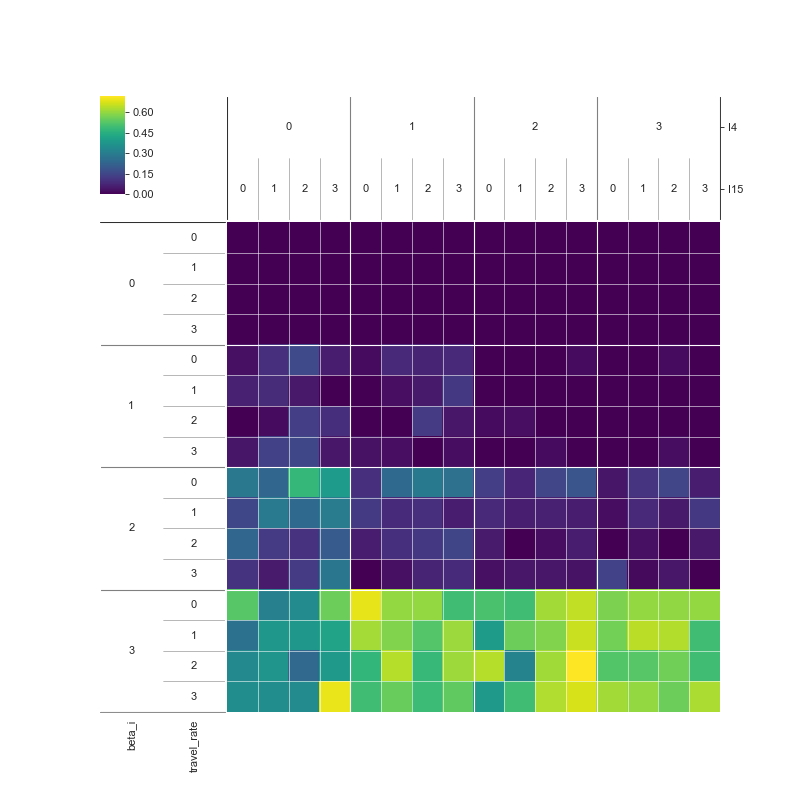

In [28]:
y1 = outcomes['Effectiveness'] > 0.8
y2 = outcomes['Difference in Met Demand'] > 0.4

y = []

for a, b in zip(y1,y2):
    y.append(a and b)
    
numpy = np.array(y)
dimensional_stacking.create_pivot_plot(x,numpy, 2, nbins=4)
plt.show()

Clearly, the transmission rate still has the highest effect, and is high (as it was for the cases with better met demand scores). This is expected as we have previously found that high effectiveness scores are related to high transmission rates.

There seems to be interaction between the travel rate, I4 and I15, with more cases occuring when I4 is high, but this isn't exactly clear cut. Higher intiial infections in I4 combined with a higher transmission rate means the ratio cummulative patients/total infections will be smaller once it receives aid.

Let's see if we see any similar/oppositve patterns in the subset with better met demand scores:

<IPython.core.display.Javascript object>


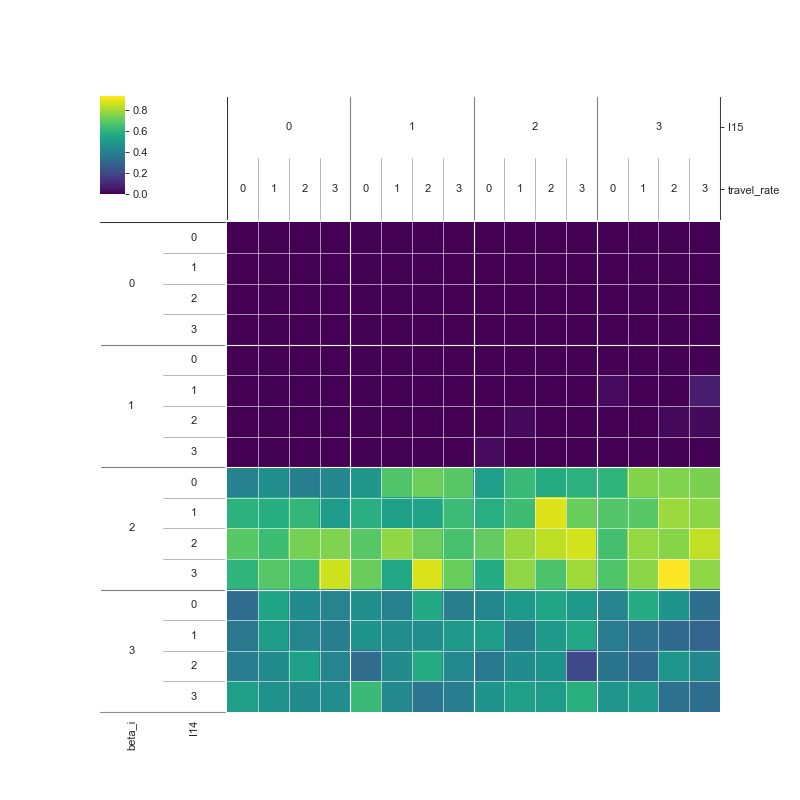

In [31]:
y1 = outcomes['Effectiveness'] > 0.8
y2 = outcomes['Difference in Met Demand'] < 0.4

y = []

for a, b in zip(y1,y2):
    y.append(a and b)
    
numpy = np.array(y)
dimensional_stacking.create_pivot_plot(x,numpy, 2, nbins=4)
plt.show()

It seems like better scores for met demand occur mainly when the transmission rate isn't as high as possible! There seems to be some interaction between the travel rate, I14 and I15. Cases are slightly more concentrated when travel rate and I14 are high.

So what does this mean? First the influence of the transmission rate. High transmission rates have already been shown to be strongly related to high efficiency scores, so it is logical that cases in this selection occur with higher transmission rates. What about the difference seen in transmission rates for good scores vs. bad scores? This has to do with the way the objective is calculated. We've already established that many regions with a small number of patients will never be discovered in the all-exploitation policy, which results in them receiving the score of 0 in pretty much all scenarios regardless of what is going on. That means the score for difference in met demand is mainly determined by what happens in the three regions which do have a chance of being discovered: I4, I14 and I15. This explains the differences we see: if the transmission rate is at it highest, and one region receives aid at timestep x, and another region receives aid at timestep x+1, the number of total infections in the second region will have grown faster than it would have at a lower transmission rate. This then means the ratio of cummulative patients/total infected is smaller the higher the transmission rate. No wait???

???

Okay moving on to the fork we can see when plotting the two equity objectives against one another. At a difference in met demand score of about 0.65 and a difference in arrival time score of 1250 there is this for in model behaviour. Let's see if we can figure out what causes this. PRIM by itself cannot find a box, let's see if PCA can help.

[MainProcess/INFO] 10000 points remaining, containing 339 cases of interest
[MainProcess/INFO] box does not meet threshold criteria, value is 0.38596491228070173, returning dump box


<IPython.core.display.Javascript object>


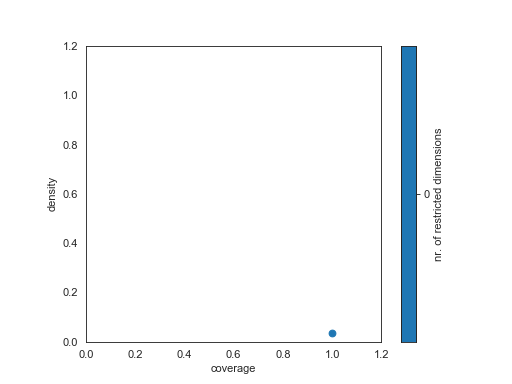

In [35]:
y1 = outcomes['Difference in Arrival Time'] < 1250
y2 = outcomes['Difference in Met Demand'] > 0.65

y = []

for a, b in zip(y1,y2):
    y.append(a and b)
    
numpy = np.array(y)

ema_logging.log_to_stderr(ema_logging.INFO)

rotated_experiments, rotation_matrix = prim.pca_preprocess(x, numpy)

prim_obj = prim.Prim(rotated_experiments, numpy, threshold=0.8)
#prim_obj = prim.Prim(x, numpy, threshold=0.8)
box10 = prim_obj.find_box()

box10.show_tradeoff()
plt.show() 

That's also not showing anything conclusive.

Let's see which factors influence these regions using dimensional stacking:

<IPython.core.display.Javascript object>


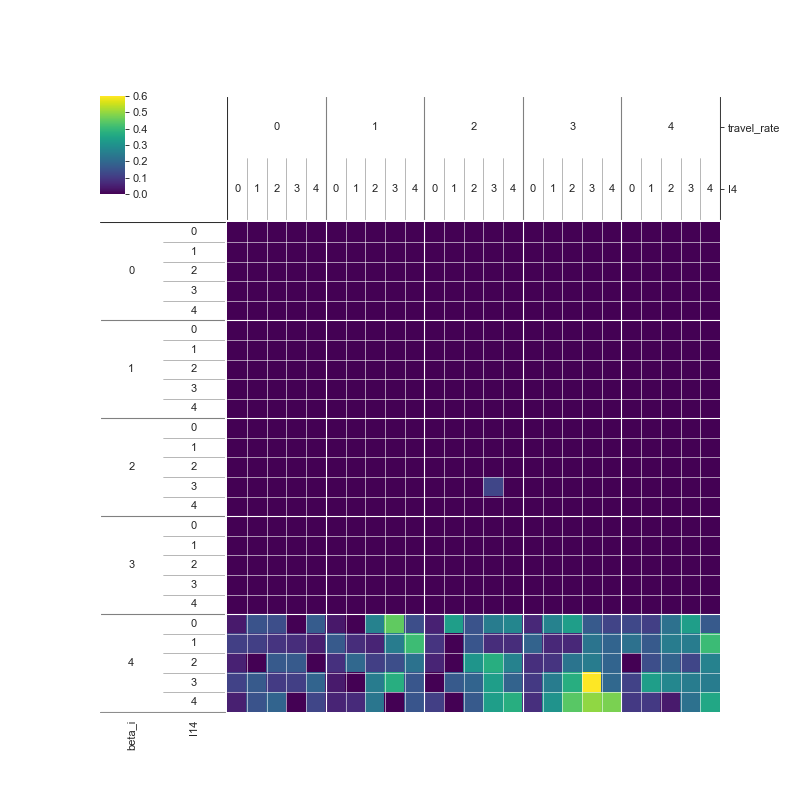

In [38]:
y1 = outcomes['Difference in Arrival Time'] < 1250
y2 = outcomes['Difference in Met Demand'] > 0.65

y = []

for a, b in zip(y1,y2):
    y.append(a and b)
    
numpy = np.array(y)
dimensional_stacking.create_pivot_plot(x,numpy, 2, nbins=5)
plt.show()

<IPython.core.display.Javascript object>


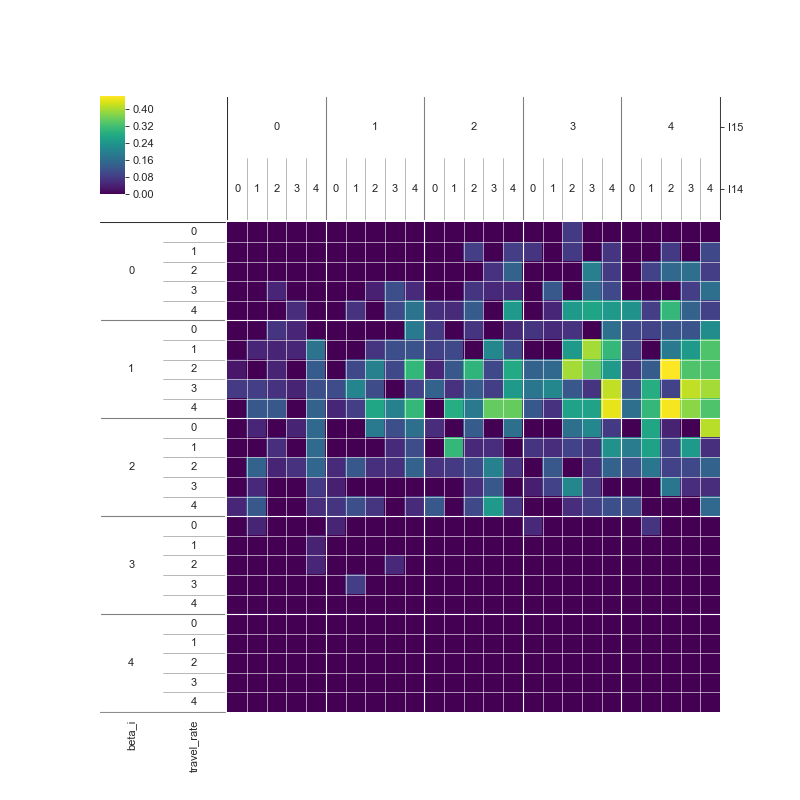

In [40]:
y1 = outcomes['Difference in Arrival Time'] > 1250
y2 = outcomes['Difference in Met Demand'] < 0.65

y = []

for a, b in zip(y1,y2):
    y.append(a and b)
    
numpy = np.array(y)
dimensional_stacking.create_pivot_plot(x,numpy, 2, nbins=5)
plt.show()

Concentration in cases is again quite low, but there is one obvious difference and that is in - again - the transmission rate. 

### Difference in Arrival Times ###

Visual analysis has already shown that the best scores in terms of arrival times are related to very low effectiveness - i.e. "equity in absence". The interaction with Difference in Met Demand has already been discussed. Still, there is a considerable spread in performance, so let's try to find out what caues bad peformance!

[MainProcess/INFO] 10000 points remaining, containing 5738 cases of interest
[MainProcess/INFO] mean: 0.9925925925925926, mass: 0.0675, coverage: 0.1167654234925061, density: 0.9925925925925926 restricted_dimensions: 4


<IPython.core.display.Javascript object>


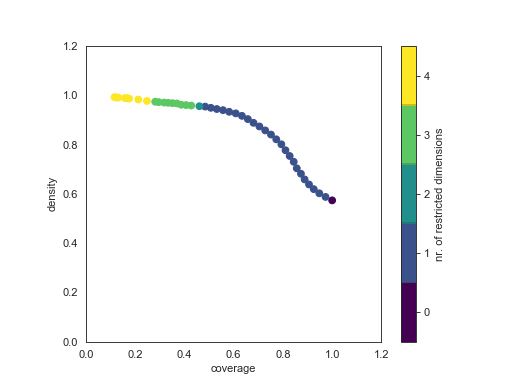

In [51]:
#y = outcomes['Difference in Arrival Time'] > 1000

y1 = outcomes['Difference in Arrival Time'] > 500
y2 = outcomes['Difference in Arrival Time'] <1000

y = []

for a, b in zip(y1,y2):
    y.append(a and b)


numpy = np.array(y)

ema_logging.log_to_stderr(ema_logging.INFO)

prim_alg = prim.Prim(x, numpy, threshold=0.8)
box11 = prim_alg.find_box()

box11.show_tradeoff()
plt.show()

coverage    0.773092
density     0.821634
id                12
mass          0.5399
mean        0.821634
res_dim            1
Name: 12, dtype: object

          box 12                       
             min       max    qp values
beta_i  0.284039  0.499961  [0.0, -1.0]



<IPython.core.display.Javascript object>


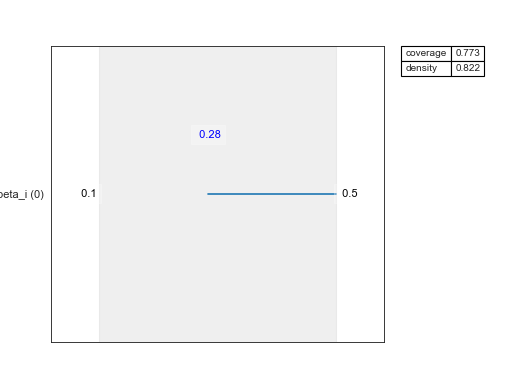

In [53]:
box11.inspect(12)
box11.inspect(12, style='graph')
plt.show()

So once again it's the transmission rate! This makes sense, as high transmission rates increase the chance of spontaneous news in hotspot regions, which means the time between demand onset and arrival of aid is smaller.

What can we find about bad scores?

[MainProcess/INFO] 10000 points remaining, containing 3796 cases of interest
[MainProcess/INFO] box does not meet threshold criteria, value is 0.5913555992141454, returning dump box


<IPython.core.display.Javascript object>


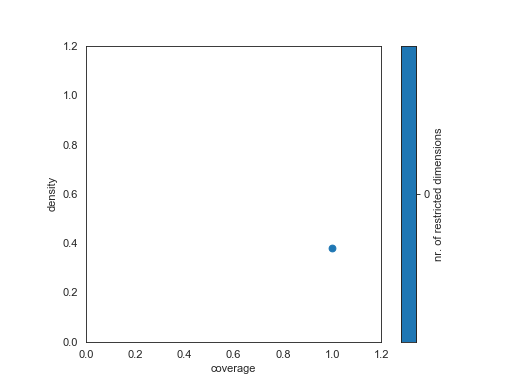

In [56]:
y = outcomes['Difference in Arrival Time'] > 900


numpy = np.array(y)

ema_logging.log_to_stderr(ema_logging.INFO)

prim_alg = prim.Prim(x, numpy, threshold=0.8)
box11 = prim_alg.find_box()

box11.show_tradeoff()
plt.show()

<IPython.core.display.Javascript object>


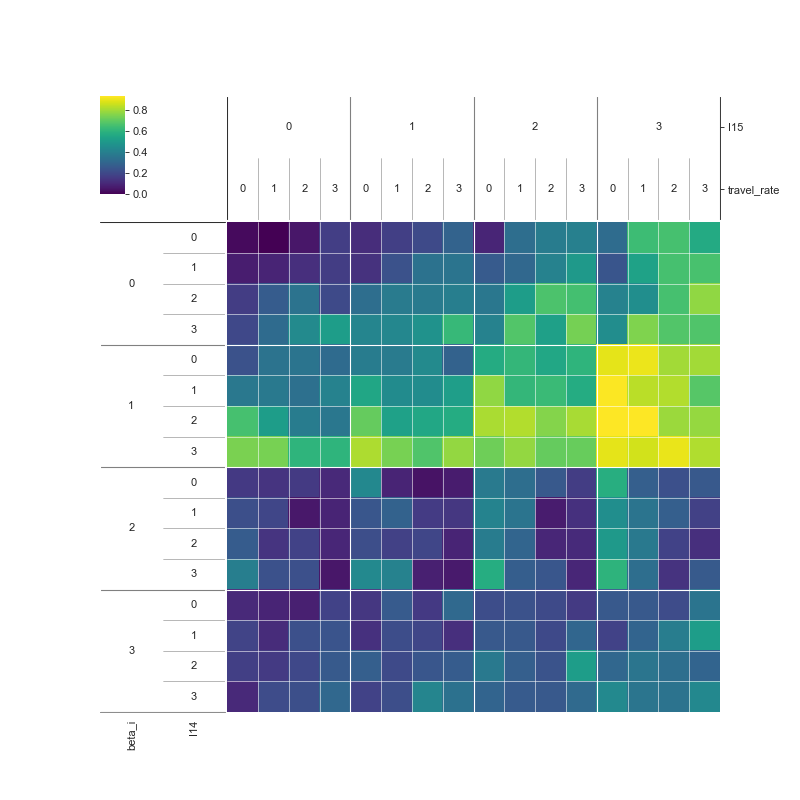

In [58]:
y = outcomes['Difference in Arrival Time'] > 900


    
numpy = np.array(y)
dimensional_stacking.create_pivot_plot(x,numpy, 2, nbins=4)
plt.show()

In [71]:
y = outcomes['Difference in Arrival Time'] > 900


fs = feature_scoring.get_ex_feature_scores(x, y)
print(fs)

(                    1
0                    
beta_i       0.469216
I15          0.185612
I14          0.124773
travel_rate  0.115214
I4           0.105185, ExtraTreesClassifier(bootstrap=True, class_weight=None, criterion='gini',
           max_depth=None, max_features=2, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=3, min_samples_split=2,
           min_weight_fraction_leaf=0, n_estimators=100, n_jobs=None,
           oob_score=True, random_state=None, verbose=0, warm_start=False))


Here you see bad results at lower transmission rates, which makes sense. What is perhaps more suprising, is that there is a high concentration of cases at low travel rates. This seems counter-intuitive at first: higher travel rates would mean the disease spreads faster across the entiry system which would lead to earlier demand-onset times everywhere, and therefore a wider distribution in time between onset and arrival (since only one ETC can be placed at each timestep) and thus a poorer score.

However, the fact that this is not to case is the result of the continous model - travel rates are never 0, which means that onset of demand in each region is the same regardless of the travel rate (excluding the randomized travelling mechanism), it's just the size of the demand at its onset that changes with the travel rate.

The reason why lower travel rates lead to poorer performance in arrival times, particularly in combination with a high I15, is due to the uncertainty reduction of neighbouring regions once an ETC is placed. For example, when an ETC becomes operation in region 15, uncertainty in the neighbouring regions (14 and 11) is reduced to 0.95. This means that there is now some chance that region 11 receives aid, even though it is not a hotspot like region 14. However, this will only happen when the lower bound for the number of cases in region 11 is higher than that of the other visible regions (which in this example can be assumed to be 14 and 15).For this to happen however, enough infected individuals need to have travelled from region 15 to region 11. Therefore, the higher the travel rate, the sooner enough individuals will have travelled from region 15 to 11 for region 11 to be chosen for the placement of an ETC.

This explanation seems a bit contradictory with the fact that poor scores are then also associated with high numbers of initial cases in region 14 and 15, but those will likely result in earlier spontaneous news for those hot-spot regions, which will increase the difference in arrival times between the hotspot regions and their neighbouring regions (as those will still need some time to develop "enough" cases to be preferred by the decision-making algorithm.

We should expect to see this theory reflected in the dimensional stacking plot for reasonable arrival time scores, so let's try:

<IPython.core.display.Javascript object>


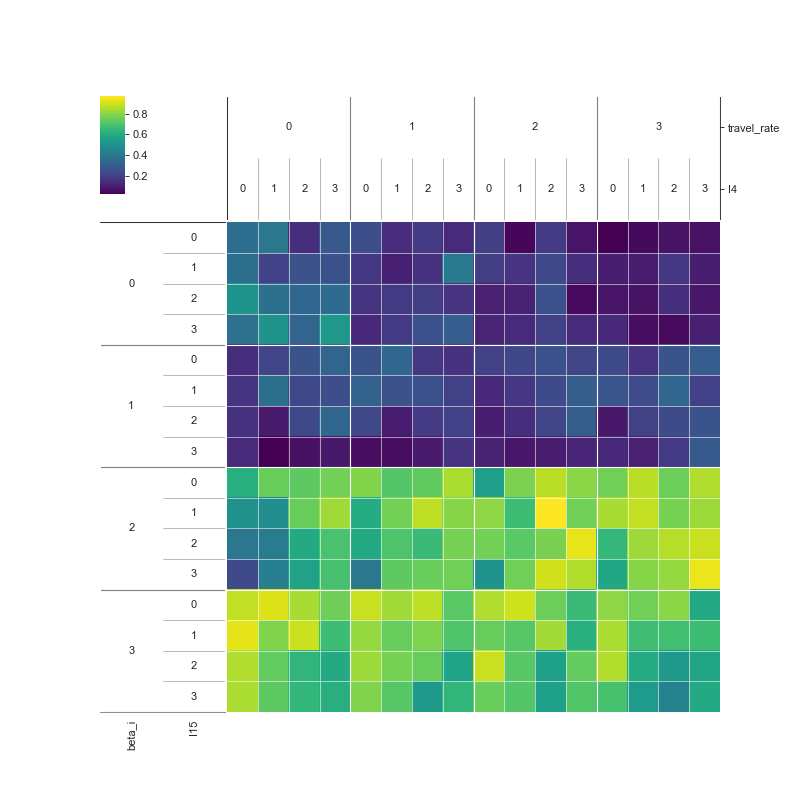

In [75]:
 
y1 = outcomes['Difference in Arrival Time'] > 500
y2 = outcomes['Difference in Arrival Time'] <900

y = []

for a, b in zip(y1,y2):
    y.append(a and b)


numpy = np.array(y)
dimensional_stacking.create_pivot_plot(x,numpy, 2, nbins=4)
plt.show()

In [73]:
y1 = outcomes['Difference in Arrival Time'] > 500
y2 = outcomes['Difference in Arrival Time'] < 900

y = []

for a, b in zip(y1,y2):
    y.append(a and b)


numpy = np.array(y)


fs = feature_scoring.get_ex_feature_scores(x, y)
print(fs)

(                    1
0                    
beta_i       0.695097
travel_rate  0.084825
I15          0.076586
I4           0.073026
I14          0.070465, ExtraTreesClassifier(bootstrap=True, class_weight=None, criterion='gini',
           max_depth=None, max_features=2, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=3, min_samples_split=2,
           min_weight_fraction_leaf=0, n_estimators=100, n_jobs=None,
           oob_score=True, random_state=None, verbose=0, warm_start=False))


Oops - we don't... at least not for the highest transmission rates. When looking at the results from pure feature scoring, we can also see that travel rate has less influence in this subset of outcomes than it does for the poor performance set. The pattern of high travel rates is visible in the 50%-75% bin of transmission rate values, so it could be that at a certain high value for transmission rates the model behaviour becomes dominated by the influence of the transmission rate. 

### Time Until Containment ###
From the visual analysis, we have seen that the scores for time until containment are split quite severly - they are mostly either above 20 or below 10. So first we'd ike to find out what causes that.

[MainProcess/INFO] 10000 points remaining, containing 8276 cases of interest
[MainProcess/INFO] mean: 0.9932885906040269, mass: 0.0894, coverage: 0.10729821169647173, density: 0.9932885906040269 restricted_dimensions: 5


<IPython.core.display.Javascript object>


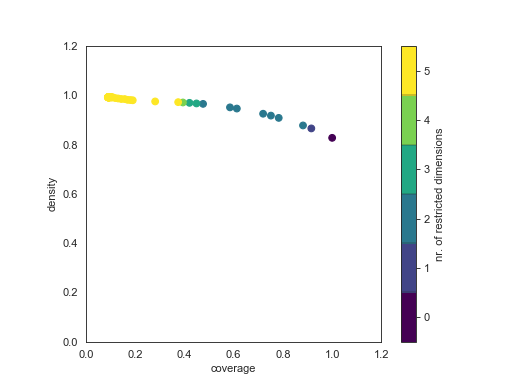

In [76]:
y = outcomes['Time until containment'] > 20


numpy = np.array(y)

ema_logging.log_to_stderr(ema_logging.INFO)

prim_alg = prim.Prim(x, numpy, threshold=0.8)
box12 = prim_alg.find_box()

box12.show_tradeoff()
plt.show()

coverage    0.783108
density     0.908594
id                 3
mass          0.7133
mean        0.908594
res_dim            2
Name: 3, dtype: object

           box 3                                          
             min       max                       qp values
I4      2.500000  8.000000   [7.171654770480568e-66, -1.0]
beta_i  0.120391  0.499961  [0.00016094983461378102, -1.0]



<IPython.core.display.Javascript object>


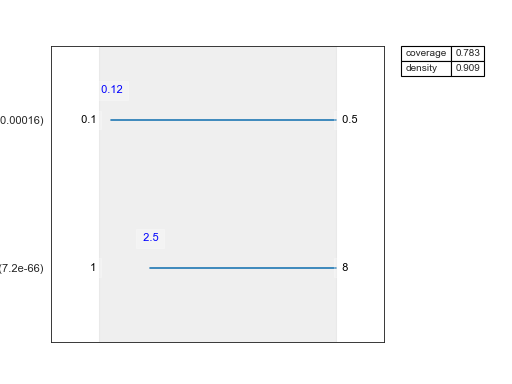

In [78]:
box12.inspect(3)
box12.inspect(3, style='graph')
plt.show()

[MainProcess/INFO] 10000 points remaining, containing 6418 cases of interest
[MainProcess/INFO] mean: 0.8120689655172414, mass: 0.058, coverage: 0.07338734808351512, density: 0.8120689655172414 restricted_dimensions: 3


<IPython.core.display.Javascript object>


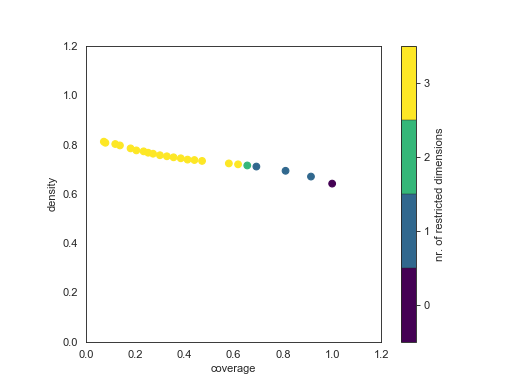

In [79]:
y = outcomes['Time until containment'] > 25


numpy = np.array(y)

ema_logging.log_to_stderr(ema_logging.INFO)

prim_alg = prim.Prim(x, numpy, threshold=0.8)
box13 = prim_alg.find_box()

box13.show_tradeoff()
plt.show()

coverage    0.810844
density     0.693867
id                 2
mass            0.75
mean        0.693867
res_dim            1
Name: 2, dtype: object

   box 2                                     
     min  max                       qp values
I4   2.5  8.0  [1.0086741529193129e-21, -1.0]



<IPython.core.display.Javascript object>


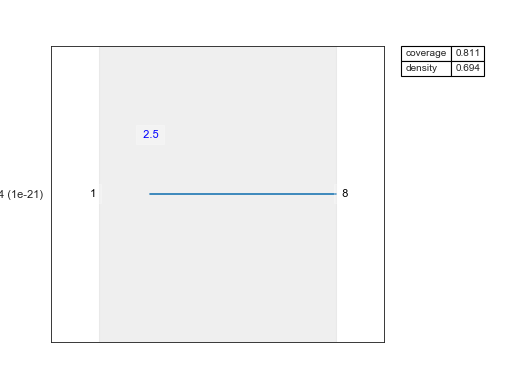

In [83]:
box13.inspect(2)
box13.inspect(2, style='graph')
plt.show()

[MainProcess/INFO] 10000 points remaining, containing 1584 cases of interest
[MainProcess/INFO] mean: 0.7151394422310757, mass: 0.0502, coverage: 0.22664141414141414, density: 0.7151394422310757 restricted_dimensions: 5


<IPython.core.display.Javascript object>


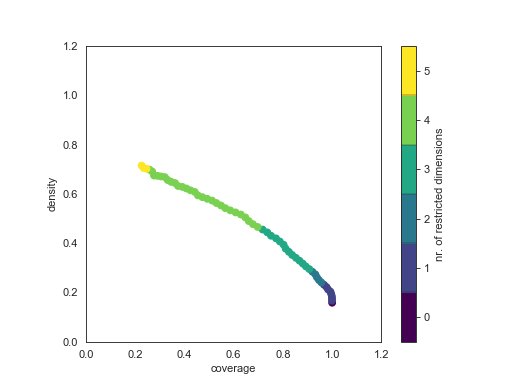

In [88]:
y = outcomes['Time until containment'] < 12.5


numpy = np.array(y)

ema_logging.log_to_stderr(ema_logging.INFO)

prim_alg = prim.Prim(rotated_experiments, numpy, threshold=0.7)
box14 = prim_alg.find_box()

box14.show_tradeoff()
plt.show()

[MainProcess/INFO] 10000 points remaining, containing 1675 cases of interest
[MainProcess/INFO] mean: 0.7180385288966725, mass: 0.0571, coverage: 0.24477611940298508, density: 0.7180385288966725 restricted_dimensions: 4


<IPython.core.display.Javascript object>


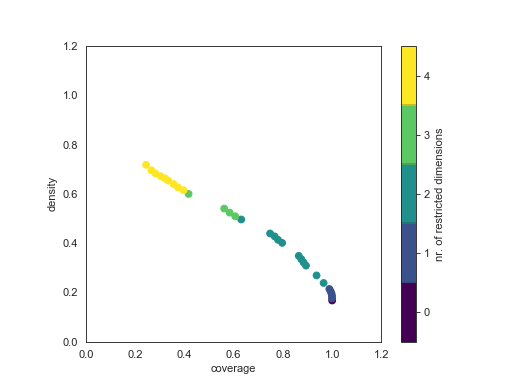

In [89]:
y = outcomes['Time until containment'] < 20


numpy = np.array(y)

ema_logging.log_to_stderr(ema_logging.INFO)

prim_alg = prim.Prim(x, numpy, threshold=0.7)
box15 = prim_alg.find_box()

box15.show_tradeoff()
plt.show()

coverage    0.797015
density     0.401262
id                12
mass          0.3327
mean        0.401262
res_dim            2
Name: 12, dtype: object

          box 12                                          
             min       max                       qp values
I4      1.000000  4.500000  [-1.0, 1.2754764271210153e-90]
beta_i  0.100037  0.363905   [-1.0, 2.852400101731905e-51]



<IPython.core.display.Javascript object>


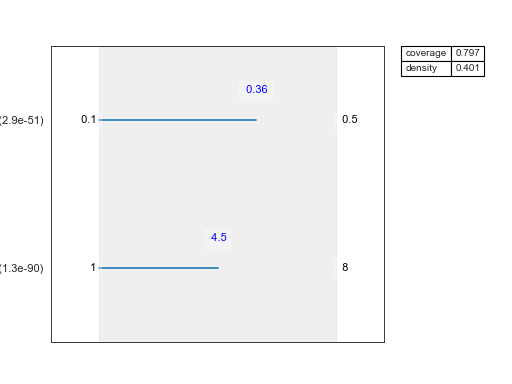

In [90]:
box15.inspect(12)
box15.inspect(12, style='graph')
plt.show()

Poor performance in terms of containment seems to be most strongly related to a high number of initial cases in region 4. This is because this region will likely be discovered only after region 14 and 15. If there is a high number of intial cases here, it will be able to contribute a proportionally large amount of the total infected cases (as well as spreading cases to neighbouring regions) before it is contained, because it will be discovered so late.

Good performance is then linked to smaller numbers - but less strongly so. PRIM actually gets a good coverage on cases which are contained before 20 timesteps, but the density in this box is poor, indicating that there is also a fair amount of cases that performed badly in this box. There is also quite some overlap in the two boxes. Therefore, the conditions found by PRIM for good performance can be understood to be necessary for, but not a guarantee of, quick containment. Given a combination of a relatively high transmission rate and initial number of cases, the situation in region 4 could still mean containment is not reached quickly.

PRIM could not find a box for scores below 12.5, but we can try to see if feature scoring and stacking can tell us more.

In [91]:
y = outcomes['Time until containment'] < 12.5

numpy = np.array(y)


fs = feature_scoring.get_ex_feature_scores(x, y)
print(fs)

(                    1
0                    
beta_i       0.350705
I4           0.308519
I15          0.137673
I14          0.108728
travel_rate  0.094375, ExtraTreesClassifier(bootstrap=True, class_weight=None, criterion='gini',
           max_depth=None, max_features=2, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=3, min_samples_split=2,
           min_weight_fraction_leaf=0, n_estimators=100, n_jobs=None,
           oob_score=True, random_state=None, verbose=0, warm_start=False))


<IPython.core.display.Javascript object>


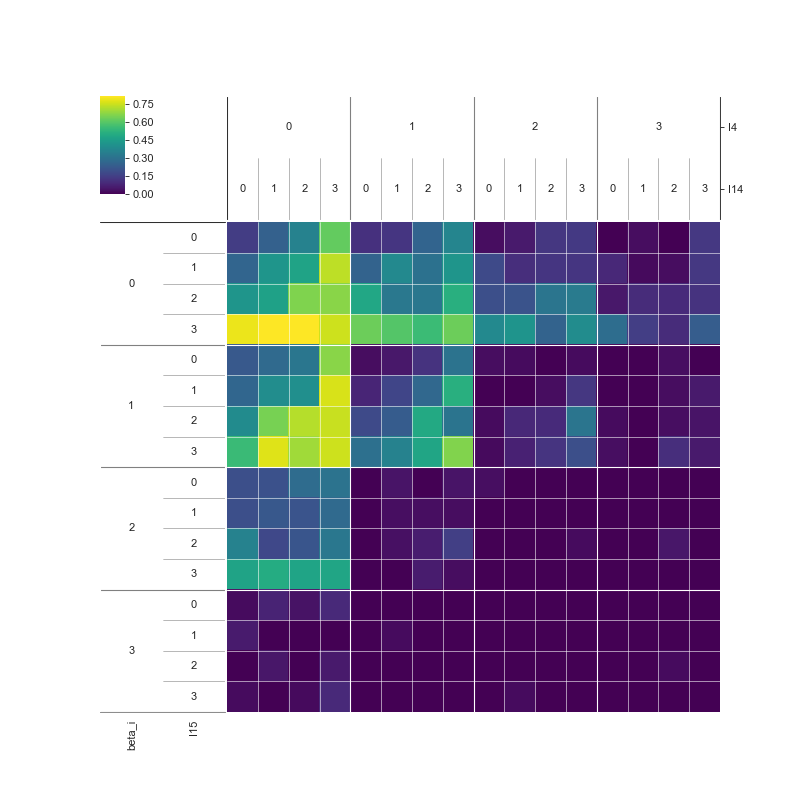

In [93]:
dimensional_stacking.create_pivot_plot(x,numpy, 2, nbins=4)
plt.show()

Feature scoring shows us that the best scores for containment are most strongly related to a low transmission rate and a low number of initial cases, which confirms the earlier hypothesis. Additionally, a benefit from high a high number of initial cases in region 14 and 15 can be seen: the higher the number of initial cases in these regions, the sooner they will be discovered by the spontaneous news function, meaning that case isolation will happen earlier on in the simulation run.

It should be noted that the concentrations in the bins for dimensional stacking aren't very high - again likely indicative that a good containment score is also dependent on luck in terms of the spontaneous news mechanism.

The fact that I4 is the most important factor in determining the speed of containment - especially for poor performance, also explains the the unclear relationship (or rather, lack thereof) seen between this objective and the four others. Since the value of I4 did not play a significant role for any of the other objectives, it makes sense that no clear relationship is visible.